
# Preconditioners in NGSolve

Preconditioners are approximative inverses which are used within iterative methods to solve linear or non-linear equations.

Available preconditioners in NGSolve are

- Jacobi and Block-Jacobi
- Direct solvers, i.e. sparse factorization
- Multigrid with different block-smoothers
- p-version element-level BDDC



In [1]:
from netgen.csg import unit_cube
from netgen.geom2d import unit_square
from ngsolve import *
import netgen.gui
%gui tk


Define a standard Poisson problem, original mesh-size $h$, polynomial order $p$, refinement levels $l$, and give the name of a preconditioner as argument.

Returns list of tuples of number of unknowns and iterations:



In [5]:
def SolveProblem(h=0.5, p=1, levels=1, 
                 eliminate_internal = False,
                 precond="local"):
    
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    # mesh = Mesh(unit_cube.GenerateMesh(maxh=h))
    fes = H1(mesh, order=p, dirichlet="bottom|left")
    
    u = fes.TrialFunction()
    v = fes.TestFunction()
    a = BilinearForm(fes, flags = { "eliminate_internal" : eliminate_internal })
    a += SymbolicBFI(grad(u)*(grad(v)))
    f = LinearForm(fes)
    f += SymbolicLFI(1*v)
    gfu = GridFunction(fes)
    Draw (gfu)
    c = Preconditioner(a, precond)
    steps = []
    
    for l in range(levels):
        if l > 0: mesh.Refine()
        fes.Update()
        a.Assemble()
        f.Assemble()
        gfu.Update()
        inv = CGSolver(a.mat, c.mat, maxsteps=1000)
        if eliminate_internal:
            f.vec.data += a.harmonic_extension_trans * f.vec
        gfu.vec.data = inv * f.vec
        if eliminate_internal:
            gfu.vec.data += a.harmonic_extension * gfu.vec
            gfu.vec.data += a.inner_solve * f.vec
        steps.append ( (fes.ndof, inv.GetSteps()) )
        Redraw ()
    return steps

The Preconditioner registers itself to the BilinearForm. Whenever the BilinearForm is re-assembled, the Preconditioner is updated as well.

In [6]:

SolveProblem(precond="local")


[(8, 4)]

The number of CG-iterations with a local (i.e. Jacobi) preconditioner is proportional to $h^{−1} \approx 2l$:

In [7]:
res_local = SolveProblem(levels=8, precond="local")
res_local


[(8, 4),
 (21, 9),
 (65, 25),
 (225, 51),
 (833, 103),
 (3201, 208),
 (12545, 418),
 (49665, 842)]

A geometric multigrid Preconditioner uses the sequence of refined meshes to define a preconditioner of optimal iteration number (and complexity as well). It uses a direct solve on the coarsest level, and block Gauss-Seidel smoothers on the refined levels

In [9]:
res_mg = SolveProblem(levels=8, precond="multigrid")
res_mg


[(8, 2),
 (21, 4),
 (65, 7),
 (225, 8),
 (833, 8),
 (3201, 8),
 (12545, 8),
 (49665, 8)]

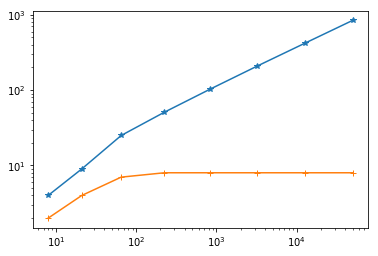

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xscale("log")
plt.yscale("log")
plt.plot(*zip(*res_local), "-*")
plt.plot(*zip(*res_mg), "-+")
plt.show()


For high order elements we use hierarchical spaces, where the (small) sub-spaces $V_E$, $V_F$, and $V_C$

are generated by basis functions associated with edges, faces, and cells:
$$V_{hp}=V_p=1+\sum_{edges\ E} V_E + \sum_{faces\ F} V_F + \sum_{cells\ C} V_C$$

The system matrix is stored as
$$
\left(
\begin{array}[ccc]
A_{VV} & A_{VE} & A_{VF} & A_{VC} \\
A_{EV} & A_{EE} & A_{EF} & A_{EC} \\
A_{FV} & A_{FE} & A_{FF} & A_{FC} \\
A_{CV} & A_{CE} & A_{CF} & A_{CC} \\
\end{array}
\right)
$$

The $A_{VV}$-block is exactly the system matrix of a lowest order method.

A multigrid for a high order method uses h-version multigrid for the lowest order block, and only local block-smoothing for the high order bubble basis functions.

In [11]:
for p in range(1,10):
    r = SolveProblem(h=0.5, p=p, levels=4, eliminate_internal=False, 
                     precond="multigrid")
    print ("p =",p,", res =",r)


p = 1 , res = [(8, 2), (21, 4), (65, 7), (225, 8)]
p = 2 , res = [(21, 5), (65, 6), (225, 8), (833, 8)]
p = 3 , res = [(40, 9), (133, 12), (481, 12), (1825, 13)]
p = 4 , res = [(65, 12), (225, 15), (833, 16), (3201, 16)]
p = 5 , res = [(96, 14), (341, 19), (1281, 20), (4961, 20)]
p = 6 , res = [(133, 16), (481, 23), (1825, 23), (7105, 23)]
p = 7 , res = [(176, 18), (645, 25), (2465, 26), (9633, 26)]
p = 8 , res = [(225, 19), (833, 27), (3201, 28), (12545, 28)]
p = 9 , res = [(280, 20), (1045, 29), (4033, 30), (15841, 30)]


In [12]:
for p in range(1,10):
    r = SolveProblem(h=0.5, p=p, levels=4, eliminate_internal=True, 
                     precond="multigrid")
    print ("p =",p,", res =",r)


p = 1 , res = [(8, 2), (21, 4), (65, 7), (225, 8)]
p = 2 , res = [(21, 5), (65, 6), (225, 8), (833, 8)]
p = 3 , res = [(40, 5), (133, 6), (481, 7), (1825, 8)]
p = 4 , res = [(65, 5), (225, 6), (833, 7), (3201, 8)]
p = 5 , res = [(96, 5), (341, 6), (1281, 7), (4961, 8)]
p = 6 , res = [(133, 5), (481, 6), (1825, 7), (7105, 8)]
p = 7 , res = [(176, 5), (645, 6), (2465, 7), (9633, 8)]
p = 8 , res = [(225, 5), (833, 6), (3201, 7), (12545, 8)]
p = 9 , res = [(280, 5), (1045, 6), (4033, 7), (15841, 8)]


For an element-wise BDDC (Balancing Domain Decomposition preconditioner with Constraints) one replaces the finite element space by a space connecting only element vertices, but leaving edge and face variables discontinuous. This allows a local elimination of edge and face variables, and thus a cheap global inverse of the replacement matrix. It is used as a preconditioner for the original system matrix:
$$C_{BDDC}^{-1}=R\tilde{A}^{−1}R^t$$

Here, $R$ is the averaging operator for the discontinous edge- and face variables.

In contrast to local or multigrid preconditioners, the BDDC - preconditioner needs access to the element matrices. This is exactly the reason why we register the preconditioner with the BilinearForm, and call the bfa.Assemble() later.

In [13]:
for p in range(1,10):
    r = SolveProblem(h=0.25, p=p, levels=3, eliminate_internal=True, 
                     precond="bddc")
    print ("p =",p,", res =",r)


p = 1 , res = [(27, 2), (89, 2), (321, 2)]
p = 2 , res = [(89, 14), (321, 19), (1217, 20)]
p = 3 , res = [(187, 18), (697, 23), (2689, 24)]
p = 4 , res = [(321, 21), (1217, 28), (4737, 29)]
p = 5 , res = [(491, 23), (1881, 31), (7361, 32)]
p = 6 , res = [(697, 25), (2689, 34), (10561, 35)]
p = 7 , res = [(939, 27), (3641, 36), (14337, 37)]
p = 8 , res = [(1217, 28), (4737, 38), (18689, 40)]
p = 9 , res = [(1531, 29), (5977, 39), (23617, 41)]



The BDDC preconditioner needs more iterations, but the work per iteration is less, so performance is similar to multigrid. The BDDC works well in shared memory parallel as well as in distributed memory mode.
